In [21]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

In [22]:
# load data
df = pd.read_parquet(
    r"https://github.com/ISL-0111/IDS701_Team_Project/raw/refs/heads/main/Data/cleaned_data.parquet"
)
df.sample(5)

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,...,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km,accept_date,delivery_duration,delivery_duration_minutes,delivery_under_30
863620,179510,52,Shanghai,3810,121.31738,30.95205,52146,14,2023-07-31 20:58:00,2023-07-31 20:58:00,...,2023-07-31 20:58:00,2023-07-31 20:58:00,121.24878,31.02114,731,4.327905,2023-07-31,0 days 00:00:00,0.0,True
1299085,3109317,81,Shanghai,4773,121.31737,31.14195,10456,1,2023-07-28 09:07:00,2023-07-28 09:07:00,...,2023-07-28 09:58:00,2023-07-28 09:58:00,121.31749,31.14202,728,0.996070,2023-07-28,0 days 00:51:00,51.0,False
953838,182139,61,Shanghai,1834,121.36322,31.35753,45254,7,2023-08-29 16:36:00,2023-08-29 16:36:00,...,2023-08-29 19:05:00,2023-08-29 19:05:00,121.36307,31.35788,829,1.253419,2023-08-29,0 days 02:29:00,149.0,False
1081635,1563800,69,Shanghai,731,121.62987,31.20033,8249,1,2023-09-12 08:41:00,2023-09-12 08:41:00,...,2023-09-12 12:44:00,2023-09-12 12:44:00,121.62949,31.20004,912,2.050513,2023-09-12,0 days 04:03:00,243.0,False
1026780,864005,66,Shanghai,2571,121.37775,31.11205,11480,1,2023-08-23 11:55:00,2023-08-23 11:55:00,...,2023-08-23 13:52:00,2023-08-23 13:52:00,121.37789,31.11212,823,3.779605,2023-08-23,0 days 01:57:00,117.0,False


In [23]:
# prepare dataset (convert time format)
df["accept_hour"] = df["accept_time"].dt.hour

In [24]:
# Filter Data for Top Regions
n_regions_under_consideration = 14
top_regions = df["region_id"].value_counts().head(n_regions_under_consideration).index
df_filtered = df[df["region_id"].isin(top_regions)]

# Keep only necessary columns
df_filtered = df_filtered[
    [
        "order_id",
        "region_id",
        "courier_id",
        "delivery_duration_minutes",
        "accept_date",
        "distance_km",
        "accept_hour",
    ]
]

print(df.shape)
df.sample(5)

(1469084, 23)


,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,...,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km,accept_date,delivery_duration,delivery_duration_minutes,delivery_under_30,accept_hour
16634,669537,1,Shanghai,74,121.52663,31.12594,36297,9,2023-06-12 17:54:00,2023-06-12 17:54:00,...,2023-06-12 18:44:00,121.52765,31.12539,612,2.207203,2023-06-12,0 days 00:50:00,50.0,False,17
11040,2644496,1,Shanghai,296,121.53516,31.06813,25017,14,2023-08-12 10:14:00,2023-08-12 10:14:00,...,2023-08-12 11:36:00,121.53638,31.06836,812,4.373110,2023-08-12,0 days 01:22:00,82.0,False,10
695774,1692208,44,Shanghai,601,121.53018,31.24292,25141,1,2023-10-08 16:17:00,2023-10-08 16:17:00,...,2023-10-08 18:07:00,121.52991,31.24320,1008,1.547270,2023-10-08,0 days 01:50:00,110.0,False,16
516751,3929517,33,Shanghai,3091,121.35237,31.28377,39684,1,2023-10-27 09:23:00,2023-10-27 09:23:00,...,2023-10-27 10:27:00,121.35952,31.27196,1027,0.861550,2023-10-27,0 days 01:04:00,64.0,False,9
500460,3362340,32,Shanghai,3527,121.45439,31.28928,59630,1,2023-09-28 15:30:00,2023-09-28 15:30:00,...,2023-09-28 17:30:00,121.45439,31.28915,928,0.855325,2023-09-28,0 days 02:00:00,120.0,False,15


In [25]:
# Create Daily Aggregations per Courier
daily_agg = (
    df_filtered.groupby(["courier_id", "accept_date"])
    .agg(
        task_count=("order_id", "nunique"),  # Number of tasks per day
        avg_delivery_duration_min=("delivery_duration_minutes", "mean"),
        avg_distance_km=("distance_km", "mean"),
        delivery_hour_mode=(
            "accept_hour",
            lambda x: x.mode()[0],
        ),  # Most frequent hour that day
    )
    .reset_index()
)
daily_agg.sample(5)

,courier_id,accept_date,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
14357,2512,2023-10-25,41,254.048780,2.889551,9
18012,3123,2023-09-17,22,73.136364,2.060204,8
17367,3031,2023-06-13,12,69.250000,0.439738,9
12936,2338,2023-09-01,52,149.942308,1.726458,16
6849,1380,2023-10-22,19,83.631579,0.429440,9


In [27]:
# Create 'high_load' Flag 
# Define high_load as days with task_count > median daily tasks across all couriers
median_daily_tasks = daily_agg["task_count"].median()
daily_agg["high_load"] = (daily_agg["task_count"] > median_daily_tasks).astype(int)
print(f'High Load = {median_daily_tasks}')

High Load = 25.0


In [29]:
# categorize the times
daily_agg["hour_bin"] = pd.cut(
    daily_agg["delivery_hour_mode"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
)
daily_agg.sample(5)

,courier_id,accept_date,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode,high_load,hour_bin
4512,681,2023-06-12,12,84.250000,0.886274,20,0,Evening
7214,1460,2023-05-05,5,164.200000,4.637249,7,0,Morning
3842,601,2023-10-10,34,102.323529,1.258575,9,1,Morning
18616,3216,2023-08-01,26,92.307692,2.721482,16,1,Afternoon
12885,2331,2023-08-11,1,147.000000,2.967408,17,0,Afternoon


In [30]:
# transform delivery duration to log 
# replace zeros with a small value (0.001)
daily_agg["log_duration"] = np.log(
    daily_agg["avg_delivery_duration_min"].replace(0, 0.001)
)
# remove outliers
lower = daily_agg["log_duration"].quantile(0.01)
upper = daily_agg["log_duration"].quantile(0.99)
daily_agg["log_duration"] = daily_agg["log_duration"].clip(lower, upper)
# check dataset
daily_agg.sample(5)

,courier_id,accept_date,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode,high_load,hour_bin,log_duration
6800,1376,2023-09-11,25,262.000000,7.413834,11,0,Morning,5.568345
12081,2172,2023-06-12,25,76.560000,0.545203,15,0,Afternoon,4.338075
3503,541,2023-06-03,25,61.200000,2.137919,10,0,Morning,4.114147
25066,4408,2023-05-08,3,34.666667,1.385080,9,0,Morning,3.545779
1030,225,2023-09-27,40,51.850000,1.690636,12,1,Morning,3.948355


In [31]:
# Run Regression
model = smf.ols(
    formula="log_duration ~ task_count + np.power(task_count, 2) + avg_distance_km + task_count * avg_distance_km + C(hour_bin)",
    data=daily_agg,
).fit(cov_type="HC3")

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     361.5
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:57:49   Log-Likelihood:                -23913.
No. Observations:               27498   AIC:                         4.784e+04
Df Residuals:                   27490   BIC:                         4.791e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [32]:
# --- Diagnostic Checks ---
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = daily_agg[["task_count", "high_load", "avg_distance_km"]]
X["interaction"] = X["task_count"] * X["avg_distance_km"]  # Add interaction term
X = sm.add_constant(X)
print(
    pd.DataFrame(
        {
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            "feature": X.columns,
        }
    )
)

        VIF          feature
0  4.375253            const
1  3.570947       task_count
2  3.560002        high_load
3  8.703068  avg_distance_km
4  8.733480      interaction


/var/folders/cv/pb7bdsd97cq7qt_b65khbfvr0000gn/T/ipykernel_8325/3646984832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["interaction"] = X["task_count"] * X["avg_distance_km"]  # Add interaction term


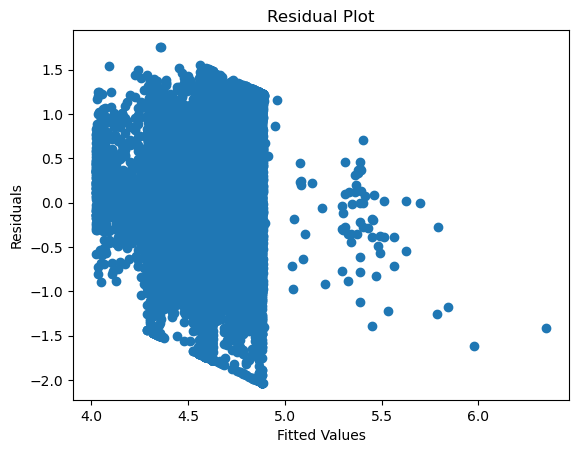

In [33]:
# Check residuals
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


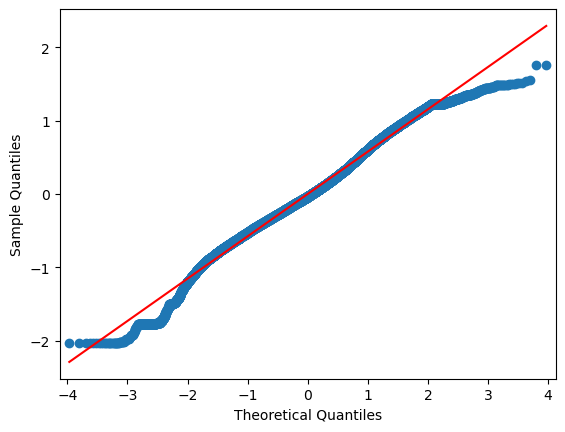

In [34]:
# qq plot
qqplot(model.resid, line="s")
plt.show()

In [35]:
# Breusch-Pagan Test for heteroscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
print("P-value:", bp_test[1])  # <0.05 confirms heteroscedasticity

P-value: 0.0
